# **1. Setup and Dependencies**
This section installs the necessary Python libraries for implementing the Bulls-Eye framework, including PyTorch Geometric for graph neural networks and other supporting packages.

In [1]:
# Install PyTorch Geometric and other required libraries
!pip install torch-geometric
!pip install networkx matplotlib pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.5 MB/s eta 0:00:00


# **2. Data Preparation and Stratified Train-Test Split**
This section defines a function to create a stratified train-test split where each design has a balanced representation in both training and testing sets. This ensures the model learns from a diverse set of designs and can generalize to unseen recipes for each design.

In [2]:
def create_stratified_train_test_split(data_df, train_size=400, test_size=100, random_state=42):
    """
    Create a stratified train-test split where each design has exactly train_size samples
    in the training set and test_size samples in the test set.

    Parameters:
    -----------
    data_df : pandas.DataFrame
        The combined dataset containing all designs and recipes
    train_size : int
        Number of samples per design to include in the training set
    test_size : int
        Number of samples per design to include in the test set
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    train_df : pandas.DataFrame
        Training dataset with train_size samples per design
    test_df : pandas.DataFrame
        Test dataset with test_size samples per design
    """
    import pandas as pd
    import numpy as np

    # Set random seed for reproducibility
    np.random.seed(random_state)

    # Get unique designs
    unique_designs = data_df['Design'].unique()

    train_dfs = []
    test_dfs = []

    for design in unique_designs:
        # Get all recipes for this design
        design_data = data_df[data_df['Design'] == design]

        # Check if we have enough samples
        total_samples = len(design_data)
        if total_samples < train_size + test_size:
            print(f"Warning: Design {design} has only {total_samples} samples, "
                  f"which is less than the requested {train_size + test_size}.")
            # Adjust sizes proportionally
            adjusted_train_size = int(total_samples * (train_size / (train_size + test_size)))
            adjusted_test_size = total_samples - adjusted_train_size
            print(f"Using {adjusted_train_size} for training and {adjusted_test_size} for testing.")
            train_size_for_design = adjusted_train_size
            test_size_for_design = adjusted_test_size
        else:
            train_size_for_design = train_size
            test_size_for_design = test_size

        # Shuffle the indices
        indices = np.arange(total_samples)
        np.random.shuffle(indices)

        # Split the indices
        train_indices = indices[:train_size_for_design]
        test_indices = indices[train_size_for_design:train_size_for_design + test_size_for_design]

        # Get the corresponding data
        design_train = design_data.iloc[train_indices]
        design_test = design_data.iloc[test_indices]

        # Append to lists
        train_dfs.append(design_train)
        test_dfs.append(design_test)

    # Concatenate all design-specific dataframes
    train_df = pd.concat(train_dfs, axis=0).reset_index(drop=True)
    test_df = pd.concat(test_dfs, axis=0).reset_index(drop=True)

    print(f"Created training set with {len(train_df)} samples and test set with {len(test_df)} samples.")
    print(f"Distribution of designs in training set:")
    print(train_df['Design'].value_counts())
    print(f"\nDistribution of designs in test set:")
    print(test_df['Design'].value_counts())

    return train_df, test_df


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import networkx as nx
import os

# Load combined data from the current directory
combined_data = pd.read_csv('final_combined.csv')
combined_data['Design'] = combined_data['Design'].str.replace('.bench', '', regex=False)
combined_data = combined_data.drop(['Final_Area', 'Final_QoR'], axis=1)
last_1000 = combined_data[-1000:]
combined_data = combined_data[:-1000]

# Check data structure
# print(combined_data.head())
Designs = combined_data['Design'].unique()
print(Designs)

# Apply the stratified train-test split
train_data, test_data = create_stratified_train_test_split(
    combined_data,
    train_size=400,
    test_size=100,
    random_state=42
)

print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

# Update bench file paths to current directory for all designs
bench_files = {design: f'{design}.bench' for design in Designs}

# Check if bench files exist
for design, bench_file in bench_files.items():
    if os.path.exists(bench_file):
        print(f"Found bench file for {design}")
    else:
        print(f"Warning: {bench_file} not found")


['apex1_orig' 'bc0_orig' 'c6288_orig' 'c7552_orig' 'i2c_orig' 'max_orig'
 'sasc_orig' 'simple_spi_orig' 'sin_orig']
Created training set with 3600 samples and test set with 900 samples.
Distribution of designs in training set:
Design
apex1_orig         400
bc0_orig           400
c6288_orig         400
c7552_orig         400
i2c_orig           400
max_orig           400
sasc_orig          400
simple_spi_orig    400
sin_orig           400
Name: count, dtype: int64

Distribution of designs in test set:
Design
apex1_orig         100
bc0_orig           100
c6288_orig         100
c7552_orig         100
i2c_orig           100
max_orig           100
sasc_orig          100
simple_spi_orig    100
sin_orig           100
Name: count, dtype: int64
Training samples: 3600
Testing samples: 900
Found bench file for apex1_orig
Found bench file for bc0_orig
Found bench file for c6288_orig
Found bench file for c7552_orig
Found bench file for i2c_orig
Found bench file for max_orig
Found bench file for sasc

# **3. AIG Graph Construction**
This section is for constructing And-Inverter Graphs (AIGs) from benchmark files, which is a key component of the Bulls-Eye framework.


In [4]:
def parse_bench_to_graph(bench_file):
    """Parse a .bench file and convert it to a graph representation """
    G = nx.DiGraph()

    # Define node types
    NODE_TYPE = {
        "PI": 0,
        "PO": 1,
        "Internal": 2
    }

    # Define edge types
    EDGE_TYPE = {
        "BUFF": 0,
        "NOT": 1
    }

    with open(bench_file, 'r') as f:
        lines = f.readlines()

    # Track primary inputs and outputs
    pi_list = []
    po_list = []
    single_input_gate_mapping = {}  # For NOT and BUFF gates

    # First pass: identify all nodes
    for line in lines:
        line = line.strip()
        if not line or line.startswith('#'):
            continue

        if line.startswith('INPUT'):
            node_name = line.split('(')[1].split(')')[0]
            pi_list.append(node_name)
            G.add_node(node_name, node_type=NODE_TYPE["PI"], node_id=node_name, num_inverted_predecessors=0)

        elif line.startswith('OUTPUT'):
            node_name = line.split('(')[1].split(')')[0]
            po_list.append(node_name)

    # Second pass: add gates and connections
    for line in lines:
        line = line.strip().replace(" ", "")
        if not line or line.startswith('#') or line.startswith('INPUT') or line.startswith('OUTPUT'):
            continue

        if '=' in line:
            output, expression = line.split('=', 1)
            output = output.strip()
            expression = expression.strip()

            if 'AND' in expression:
                # Handle AND gates
                try:
                    input1 = expression.split('(')[1].split(',')[0].strip()
                    input2 = expression.split(',')[1].split(')')[0].strip()

                    # Add node for the AND gate
                    G.add_node(output, node_type=NODE_TYPE["Internal"], node_id=output, num_inverted_predecessors=0)

                    # Process inputs and add edges
                    num_inverted = 0
                    for inp in [input1, input2]:
                        is_inverted = inp.startswith('!')
                        actual_inp = inp[1:] if is_inverted else inp

                        # Add edge with appropriate type
                        edge_type = EDGE_TYPE["NOT"] if is_inverted else EDGE_TYPE["BUFF"]
                        G.add_edge(actual_inp, output, edge_type=edge_type)

                        if is_inverted:
                            num_inverted += 1

                    # Update the number of inverted predecessors
                    G.nodes[output]['num_inverted_predecessors'] = num_inverted

                    # If this is a primary output, add special handling
                    if output in po_list:
                        po_node = f"{output}_po"
                        G.add_node(po_node, node_type=NODE_TYPE["PO"], node_id=po_node, num_inverted_predecessors=0)
                        G.add_edge(output, po_node, edge_type=EDGE_TYPE["BUFF"])
                except Exception as e:
                    print(f"Error processing AND gate: {line} - {e}")

            elif 'NOT' in expression:
                # Handle NOT gates
                try:
                    input_pin = expression.split('(')[1].split(')')[0].strip()
                    single_input_gate_mapping[output] = input_pin

                    # If this is a primary output, add a node for it
                    if output in po_list:
                        po_node = f"{output}_po"
                        G.add_node(po_node, node_type=NODE_TYPE["PO"], node_id=po_node, num_inverted_predecessors=1)

                        # Add edge from input to PO with NOT type
                        G.add_edge(input_pin, po_node, edge_type=EDGE_TYPE["NOT"])
                except Exception as e:
                    print(f"Error processing NOT gate: {line} - {e}")

            elif 'BUFF' in expression:
                # Handle BUFF gates
                try:
                    input_pin = expression.split('(')[1].split(')')[0].strip()
                    single_input_gate_mapping[output] = input_pin

                    # If this is a primary output, add a node for it
                    if output in po_list:
                        po_node = f"{output}_po"
                        G.add_node(po_node, node_type=NODE_TYPE["PO"], node_id=po_node, num_inverted_predecessors=0)

                        # Add edge from input to PO with BUFF type
                        G.add_edge(input_pin, po_node, edge_type=EDGE_TYPE["BUFF"])
                except Exception as e:
                    print(f"Error processing BUFF gate: {line} - {e}")

            else:
                # Handle direct assignments
                try:
                    is_inverted = expression.startswith('!')
                    actual_inp = expression[1:] if is_inverted else expression

                    # Add node if it's not already in the graph
                    if output not in G.nodes():
                        G.add_node(output, node_type=NODE_TYPE["Internal"], node_id=output, num_inverted_predecessors=1 if is_inverted else 0)

                    # Add edge with appropriate type
                    edge_type = EDGE_TYPE["NOT"] if is_inverted else EDGE_TYPE["BUFF"]
                    G.add_edge(actual_inp, output, edge_type=edge_type)

                    # If this is a primary output, add special handling
                    if output in po_list:
                        po_node = f"{output}_po"
                        G.add_node(po_node, node_type=NODE_TYPE["PO"], node_id=po_node, num_inverted_predecessors=0)
                        G.add_edge(output, po_node, edge_type=EDGE_TYPE["BUFF"])
                except Exception as e:
                    print(f"Error processing direct assignment: {line} - {e}")

    # Print statistics for debugging
    pi_count = sum(1 for _, attr in G.nodes(data=True) if attr.get('node_type') == NODE_TYPE["PI"])
    po_count = sum(1 for _, attr in G.nodes(data=True) if attr.get('node_type') == NODE_TYPE["PO"])
    internal_count = sum(1 for _, attr in G.nodes(data=True) if attr.get('node_type') == NODE_TYPE["Internal"])
    inverted_edge_count = sum(1 for _, _, attr in G.edges(data=True) if attr.get('edge_type') == EDGE_TYPE["NOT"])

    print(f"Graph statistics: {pi_count} inputs, {po_count} outputs, {internal_count} internal nodes")
    # print(f"Edge inversions: {inverted_edge_count} inverted edges out of {G.number_of_edges()} total")

    return G


# **4. Bench File to Graph Conversion**
This section implements functions to parse benchmark files into graph representations and convert them to PyTorch Geometric data objects, which are suitable for graph neural networks.

In [5]:
def graph_to_pyg_data(G):
    """Convert NetworkX graph to PyTorch Geometric Data object based on OpenABC approach"""
    # Create node mapping
    node_map = {node: i for i, node in enumerate(G.nodes())}

    # Create node features
    # [node_type_one_hot (3 dims), num_inverted_predecessors (1 dim)]
    x = torch.zeros((len(G.nodes()), 4), dtype=torch.float)

    for node, idx in node_map.items():
        node_type = G.nodes[node].get('node_type', 2)  # Default to internal node

        # One-hot encoding for node type (PI, PO, internal)
        if node_type == 0:  # PI
            x[idx, 0:3] = torch.tensor([1, 0, 0], dtype=torch.float)
        elif node_type == 1:  # PO
            x[idx, 0:3] = torch.tensor([0, 1, 0], dtype=torch.float)
        else:  # Internal
            x[idx, 0:3] = torch.tensor([0, 0, 1], dtype=torch.float)

        # Number of inverted predecessors
        num_inverted = G.nodes[node].get('num_inverted_predecessors', 0)
        x[idx, 3] = num_inverted

    # Create edge index and attributes
    edge_index = []
    edge_attr = []

    for u, v, data in G.edges(data=True):
        edge_index.append([node_map[u], node_map[v]])

        # Edge attribute: 1 if inverted (NOT), 0 if buffer (BUFF)
        is_inverted = data.get('edge_type', 0) == 1
        edge_attr.append([1.0 if is_inverted else 0.0])

    if not edge_index:  # Handle empty graphs
        edge_index = torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.zeros((0, 1), dtype=torch.float)
    else:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Create PyG Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    return data


In [6]:
# Process each design
design_graphs = {}
for design in Designs:
    bench_file = f'{design}.bench'
    if os.path.exists(bench_file):
        G = parse_bench_to_graph(bench_file)
        pyg_data = graph_to_pyg_data(G)
        design_graphs[design] = pyg_data
        print(f"Processed {design}: {len(G.nodes())} nodes, {len(G.edges())} edges")

        # Display node type distribution
        node_types = [attr.get('node_type', 2) for _, attr in G.nodes(data=True)]
        type_counts = {0: 0, 1: 0, 2: 0}  # PI, PO, Internal
        for t in node_types:
            type_counts[t] = type_counts.get(t, 0) + 1
        print(f"Node types: {type_counts[0]} PIs, {type_counts[1]} POs, {type_counts[2]} internal nodes")

        # Display the 4-dimensional node features for the first 5 nodes
        # print(f"First 5 node features for {design}:")
        # print(pyg_data.x[:5])

        # Display the feature dimensions
        # print(f"Node feature dimensions: {pyg_data.x.shape}")

        # Display unique values in the 4th dimension (inversion count)
        # unique_inversion_counts = torch.unique(pyg_data.x[:, 3])
        # print(f"Unique inversion counts: {unique_inversion_counts}")

        # Count frequency of each inversion count
        inversion_counts = pyg_data.x[:, 3].numpy()
        unique_counts, count_frequency = np.unique(inversion_counts, return_counts=True)
        print("Inversion count distribution:")
        # for value, freq in zip(unique_counts, count_frequency):
        #     print(f"  Count {value}: {freq} nodes ({freq/len(inversion_counts)*100:.2f}%)")

        # Verify edge attributes (inversions)
        # print(f"Edge attribute shape: {pyg_data.edge_attr.shape}")
        if len(pyg_data.edge_attr) > 0:
            inverted_count = (pyg_data.edge_attr == 1.0).sum().item()
            print(f"Inverted edges: {inverted_count} out of {len(pyg_data.edge_attr)} ({inverted_count/len(pyg_data.edge_attr)*100:.2f}%)")
            # print(f"Sample edge attributes (first 5): \n{pyg_data.edge_attr[-5:]}")
    else:
        print(f"Warning: {bench_file} not found")


Graph statistics: 45 inputs, 45 outputs, 1578 internal nodes
Processed apex1_orig: 1918 nodes, 3201 edges
Node types: 45 PIs, 45 POs, 1828 internal nodes
Inversion count distribution:
Inverted edges: 37 out of 3201 (1.16%)
Graph statistics: 26 inputs, 11 outputs, 1592 internal nodes
Processed bc0_orig: 2816 nodes, 3195 edges
Node types: 26 PIs, 11 POs, 2779 internal nodes
Inversion count distribution:
Inverted edges: 11 out of 3195 (0.34%)
Graph statistics: 32 inputs, 32 outputs, 2337 internal nodes
Processed c6288_orig: 4691 nodes, 4706 edges
Node types: 32 PIs, 32 POs, 4627 internal nodes
Inversion count distribution:
Inverted edges: 1 out of 4706 (0.02%)
Graph statistics: 207 inputs, 107 outputs, 2198 internal nodes
Processed c7552_orig: 4209 nodes, 4503 edges
Node types: 207 PIs, 107 POs, 3895 internal nodes
Inversion count distribution:
Inverted edges: 53 out of 4503 (1.18%)
Graph statistics: 177 inputs, 128 outputs, 1169 internal nodes
Processed i2c_orig: 2281 nodes, 2466 edges
N

In [7]:
class AIGEncoder(nn.Module):
    def __init__(self, node_features=4, hidden_dim=64):
        super().__init__()
        # Two GCN layers with batch normalization
        self.gcn1 = GCNConv(node_features, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def forward(self, x, edge_index, edge_attr):
        # First GCN layer with ReLU activation
        h = self.gcn1(x, edge_index, edge_attr.squeeze(-1))
        h = self.bn1(h)
        h = F.relu(h)  # ReLU after batch normalization

        # Second GCN layer without ReLU activation
        h = self.gcn2(h, edge_index, edge_attr.squeeze(-1))
        h = self.bn2(h)
        h = F.relu(h)  # ReLU after batch normalization

        # Readout: concatenate mean and max pooling
        h_mean = global_mean_pool(h, batch=None).view(1, -1)  # [1, hidden_dim]
        h_max = global_max_pool(h, batch=None).view(1, -1)    # [1, hidden_dim]
        graph_embed = torch.cat([h_mean, h_max], dim=1)       # [1, 2*hidden_dim]

        return graph_embed


In [8]:
# Test the AIG encoder with all available graphs
# Initialize the AIG encoder
aig_encoder = AIGEncoder()

# Process all graphs and store their embeddings
graph_embeddings = {}
for design, pyg_data in design_graphs.items():
    # Process the graph
    graph_embedding = aig_encoder(pyg_data.x, pyg_data.edge_index, pyg_data.edge_attr)
    graph_embeddings[design] = graph_embedding

    # Print information about each graph's embedding
    # print(f"{design} graph embedding shape: {graph_embedding.shape}")

# Print total number of processed designs
print(f"\nTotal number of designs processed: {len(graph_embeddings)}")

# Verify consistency of embedding dimensions
embedding_dims = [emb.shape[1] for emb in graph_embeddings.values()]
if len(set(embedding_dims)) == 1:
    print(f"All embeddings have consistent dimension: {embedding_dims[0]}")
else:
    print(f"Warning: Inconsistent embedding dimensions: {set(embedding_dims)}")



Total number of designs processed: 9
All embeddings have consistent dimension: 128


# **5. Recipe Encoding**
This section implements functions to encode synthesis recipes into numerical features and create a neural network for recipe embedding.

In [9]:
def encode_recipe(recipe_str, max_length=20):
    """
    Convert synthesis recipe string to numerical features according to Bulls-Eye paper

    Args:
        recipe_str: String containing synthesis commands separated by semicolons
        max_length: Maximum length of the recipe sequence to consider

    Returns:
        torch.Tensor: Encoded recipe as a sequence of integers
    """
    # Map commands to indices (using 0 for padding)
    cmd_map = {
        'b': 1, 'rw': 2, 'rf': 3, 'rs': 4,
        'st': 5, 'rwz': 6, 'f': 7, 'rfz': 8
    }

    # Split recipe into commands
    commands = recipe_str.replace(';', ' ').split()
    commands = [cmd.strip() for cmd in commands if cmd.strip()]

    # Create a fixed-length recipe representation
    recipe_encoded = torch.zeros(max_length, dtype=torch.long)

    # Fill in the recipe commands
    for i, cmd in enumerate(commands[:max_length]):
        if cmd in cmd_map:
            recipe_encoded[i] = cmd_map[cmd]

    return recipe_encoded


In [10]:
class RecipeEncoder(nn.Module):
    def __init__(self, vocab_size=9, embed_dim=20, hidden_dim=64):
        """
        Recipe encoding network using multiple 1D CNNs with different kernel sizes

        Args:
            vocab_size: Size of the command vocabulary (including padding)
            embed_dim: Dimension of the command embeddings
            hidden_dim: Dimension of the output recipe embedding
        """
        super().__init__()

        # Command embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # 1D CNNs with different kernel sizes as in Bulls-Eye
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(1, 16, kernel_size=4, stride=1, padding=1)
        self.conv3 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv1d(1, 16, kernel_size=6, stride=1, padding=2)

        # Fully connected layer for recipe embedding
        self.fc = nn.Linear(16 * 4, hidden_dim)  # 16 filters * 4 CNN layers

    def forward(self, x):
        """
        Forward pass of the recipe encoder

        Args:
            x: Tensor of shape [batch_size, seq_len] containing recipe commands

        Returns:
            Tensor of shape [batch_size, hidden_dim] containing recipe embeddings
        """
        # Embed commands
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]

        # Reshape for 1D convolution
        # We treat the embedding dimension as a "channel" dimension for the CNNs
        conv_input = embedded.mean(dim=2).unsqueeze(1)  # [batch_size, 1, seq_len]

        # Apply CNNs with different kernel sizes
        conv1_out = F.relu(self.conv1(conv_input))  # [batch_size, 16, seq_len]
        conv2_out = F.relu(self.conv2(conv_input))  # [batch_size, 16, seq_len]
        conv3_out = F.relu(self.conv3(conv_input))  # [batch_size, 16, seq_len]
        conv4_out = F.relu(self.conv4(conv_input))  # [batch_size, 16, seq_len]

        # Global max pooling
        conv1_out = F.adaptive_max_pool1d(conv1_out, 1).squeeze(2)  # [batch_size, 16]
        conv2_out = F.adaptive_max_pool1d(conv2_out, 1).squeeze(2)  # [batch_size, 16]
        conv3_out = F.adaptive_max_pool1d(conv3_out, 1).squeeze(2)  # [batch_size, 16]
        conv4_out = F.adaptive_max_pool1d(conv4_out, 1).squeeze(2)  # [batch_size, 16]

        # Concatenate CNN outputs
        concat_out = torch.cat([conv1_out, conv2_out, conv3_out, conv4_out], dim=1)  # [batch_size, 64]

        # Final recipe embedding
        recipe_embed = F.relu(self.fc(concat_out))  # [batch_size, hidden_dim]

        return recipe_embed


In [11]:
# Encode all recipes in both train_data and test_data
print(f"Number of recipes in train_data: {len(train_data)}")
print(f"Number of recipes in test_data: {len(test_data)}")

# Encode each recipe in the training data
train_encoded_recipes = torch.stack([encode_recipe(recipe) for recipe in train_data['Recipe']])
print(f"Train encoded recipes shape: {train_encoded_recipes.shape}")

# Encode each recipe in the test data
test_encoded_recipes = torch.stack([encode_recipe(recipe) for recipe in test_data['Recipe']])
print(f"Test encoded recipes shape: {test_encoded_recipes.shape}")

# Process all recipes through the recipe encoder
recipe_encoder = RecipeEncoder()

# Process training recipes
train_recipe_embeddings = recipe_encoder(train_encoded_recipes)
print(f"Train recipe embeddings shape: {train_recipe_embeddings.shape}")

# Process test recipes
test_recipe_embeddings = recipe_encoder(test_encoded_recipes)
print(f"Test recipe embeddings shape: {test_recipe_embeddings.shape}")

# Display sample embeddings
# print(f"First training recipe embedding (first 10 dimensions):\n{train_recipe_embeddings[0][:10]}")
# print(f"First test recipe embedding (first 10 dimensions):\n{test_recipe_embeddings[0][:10]}")


Number of recipes in train_data: 3600
Number of recipes in test_data: 900
Train encoded recipes shape: torch.Size([3600, 20])
Test encoded recipes shape: torch.Size([900, 20])
Train recipe embeddings shape: torch.Size([3600, 64])
Test recipe embeddings shape: torch.Size([900, 64])


# **6. Delay Predictor Model**
This section implements the delay predictor model, which combines graph and recipe embeddings to predict synthesis delay.

In [12]:
class DelayPredictor(nn.Module):
    def __init__(self, aig_encoder, recipe_encoder, input_dim=192, hidden_dim=512, lr=0.01):
        super().__init__()
        self.aig_encoder = aig_encoder
        self.recipe_encoder = recipe_encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)

        # Initialize optimizer and loss function
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

    def train_step(self, x, y):
        # Set model to training mode
        self.train()

        # Create fresh tensors by detaching from the computation graph
        x = x.detach().clone().requires_grad_(True)
        y = y.detach().clone()

        # Zero the parameter gradients
        self.optimizer.zero_grad()

        # Forward pass
        outputs = self(x)
        loss = self.criterion(outputs, y)

        # Backward pass and optimize
        loss.backward()  # No need for retain_graph=True now
        self.optimizer.step()

        return loss.item()



    def evaluate(self, x, y):
        """Evaluate the model on the given data"""
        # Set model to evaluation mode
        self.eval()

        with torch.no_grad():
            outputs = self(x)
            loss = self.criterion(outputs, y)

        return outputs, loss.item()


In [13]:
# Load the saved model
def load_bulls_eye_model(model_path='bulls_eye_zero_shot_model.pt', device='cpu'):
    # Load the saved data
    model_data = torch.load(model_path, map_location=device)

    # Initialize the encoders
    aig_encoder = AIGEncoder(node_features=4, hidden_dim=64)
    recipe_encoder = RecipeEncoder(vocab_size=9, embed_dim=20, hidden_dim=64)

    # Load encoder states
    aig_encoder.load_state_dict(model_data['aig_encoder_state_dict'])
    recipe_encoder.load_state_dict(model_data['recipe_encoder_state_dict'])

    # Initialize the full model
    model = DelayPredictor(
        aig_encoder=aig_encoder,
        recipe_encoder=recipe_encoder,
        input_dim=model_data['input_dim'],
        hidden_dim=model_data['hidden_dim']
    )

    # Load the model state
    model.load_state_dict(model_data['model_state_dict'])

    # Print model metrics
    print("Loaded model metrics:")
    for metric, value in model_data['metrics'].items():
        print(f"  {metric.upper()}: {value:.4f}")

    return model, aig_encoder, recipe_encoder, model_data

# Example usage:
# model, aig_encoder, recipe_encoder, model_data = load_bulls_eye_model()


In [14]:
# Prepare training data with correct design-recipe pairing
train_combined_embeddings = []
for idx, row in train_data.iterrows():
    design = row['Design']
    recipe_idx = train_data.index.get_loc(idx)
    recipe_embed = train_recipe_embeddings[recipe_idx]

    # Get the corresponding graph embedding for this design
    graph_embed = graph_embeddings[design]

    # Combine the embeddings
    combined = torch.cat([graph_embed, recipe_embed.unsqueeze(0)], dim=1)
    train_combined_embeddings.append(combined)

# Stack all combined embeddings
train_combined_embedding = torch.cat(train_combined_embeddings, dim=0)

# Prepare testing data with correct design-recipe pairing
test_combined_embeddings = []
for idx, row in test_data.iterrows():
    design = row['Design']
    recipe_idx = test_data.index.get_loc(idx)
    recipe_embed = test_recipe_embeddings[recipe_idx]

    # Get the corresponding graph embedding for this design
    graph_embed = graph_embeddings[design]

    # Combine the embeddings
    combined = torch.cat([graph_embed, recipe_embed.unsqueeze(0)], dim=1)
    test_combined_embeddings.append(combined)

# Stack all combined embeddings
test_combined_embedding = torch.cat(test_combined_embeddings, dim=0)

# Prepare labels
train_labels = torch.tensor(train_data['Final_Delay'].values, dtype=torch.float).unsqueeze(1)
test_labels = torch.tensor(test_data['Final_Delay'].values, dtype=torch.float).unsqueeze(1)

# Implement k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Convert tensors to numpy for KFold
train_data_np = train_combined_embedding.detach().numpy()
train_labels_np = train_labels.detach().numpy()

# Store best model based on validation performance
best_model = None
best_val_loss = float('inf')

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_data_np)):
    print(f"Fold {fold+1}/{k_folds}")

    # Convert indices back to tensors
    fold_train_data = torch.tensor(train_data_np[train_idx], dtype=torch.float)
    fold_train_labels = torch.tensor(train_labels_np[train_idx], dtype=torch.float)
    fold_val_data = torch.tensor(train_data_np[val_idx], dtype=torch.float)
    fold_val_labels = torch.tensor(train_labels_np[val_idx], dtype=torch.float)

    # Determine input dimension based on the actual data
    input_dim = fold_train_data.shape[1]

    # Initialize new model for this fold
    fold_model = DelayPredictor(aig_encoder, recipe_encoder, input_dim=input_dim, hidden_dim=512, lr=0.01)

    # Training loop for this fold
    num_epochs = 200
    for epoch in range(num_epochs):
        # Training phase
        train_loss = fold_model.train_step(fold_train_data, fold_train_labels)

        # Evaluation on validation set
        if (epoch + 1) % 20 == 0 or epoch == 0:
            val_outputs, val_loss = fold_model.evaluate(fold_val_data, fold_val_labels)
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Final validation for this fold
    _, final_val_loss = fold_model.evaluate(fold_val_data, fold_val_labels)
    print(f"Fold {fold+1} Final Validation Loss: {final_val_loss:.4f}")

    # Save best model across folds
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = fold_model.state_dict().copy()
        print(f"New best model found with validation loss: {best_val_loss:.4f}")

# Use the best model from cross-validation
model = DelayPredictor(aig_encoder, recipe_encoder, input_dim=train_combined_embedding.shape[1], hidden_dim=512)
model.load_state_dict(best_model)

# Final evaluation on test set
final_outputs, final_loss = model.evaluate(test_combined_embedding, test_labels)

# Calculate additional metrics
with torch.no_grad():
    # Mean Absolute Error
    mae = F.l1_loss(final_outputs, test_labels).item()

    # Root Mean Squared Error
    rmse = torch.sqrt(F.mse_loss(final_outputs, test_labels)).item()

    # Mean Absolute Percentage Error
    mape = torch.mean(torch.abs((test_labels - final_outputs) / test_labels)) * 100

print(f"Test MSE: {final_loss:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape.item():.2f}%")

Fold 1/5
Epoch [1/200], Train Loss: 2181625.0000, Val Loss: 1863479.5000
Epoch [20/200], Train Loss: 1429826.2500, Val Loss: 1138322.8750
Epoch [40/200], Train Loss: 486532.6562, Val Loss: 468433.6562
Epoch [60/200], Train Loss: 81101.9141, Val Loss: 76998.9531
Epoch [80/200], Train Loss: 13383.8330, Val Loss: 13794.0898
Epoch [100/200], Train Loss: 7685.1235, Val Loss: 7395.8203
Epoch [120/200], Train Loss: 5416.6016, Val Loss: 5160.2007
Epoch [140/200], Train Loss: 4440.3154, Val Loss: 4024.6494
Epoch [160/200], Train Loss: 3943.5181, Val Loss: 3462.4348
Epoch [180/200], Train Loss: 3659.6753, Val Loss: 3195.4094
Epoch [200/200], Train Loss: 3329.7673, Val Loss: 2915.6379
Fold 1 Final Validation Loss: 2915.6379
New best model found with validation loss: 2915.6379
Fold 2/5
Epoch [1/200], Train Loss: 2172236.0000, Val Loss: 1871552.7500
Epoch [20/200], Train Loss: 1934208.7500, Val Loss: 1797429.3750
Epoch [40/200], Train Loss: 503532.8750, Val Loss: 398664.5000
Epoch [60/200], Train L

In [15]:
# Save the best model from cross-validation
save_path = 'bulls_eye_zero_shot_model.pt'

# Create a dictionary with all the important components and metrics
model_data = {
    'model_state_dict': best_model,  # The best model state dict from cross-validation
    'aig_encoder_state_dict': aig_encoder.state_dict(),  # Save the AIG encoder separately
    'recipe_encoder_state_dict': recipe_encoder.state_dict(),  # Save the recipe encoder separately
    'input_dim': train_combined_embedding.shape[1],  # Input dimension for the model
    'hidden_dim': 512,  # Hidden dimension used
    'metrics': {
        'mse': final_loss,
        'mae': mae,
        'rmse': rmse,
        'mape': mape.item()
    },
    'training_info': {
        'k_folds': k_folds,
        'best_val_loss': best_val_loss,
        'num_epochs': num_epochs
    },
    'data_info': {
        'train_size': len(train_data),
        'test_size': len(test_data),
        'designs': list(Designs)
    }
}

# Save the model data
torch.save(model_data, save_path)

print(f"Model saved to {save_path}")

# Also save the graph embeddings for future use
graph_embeddings_path = 'graph_embeddings.pt'
torch.save(graph_embeddings, graph_embeddings_path)
print(f"Graph embeddings saved to {graph_embeddings_path}")


Model saved to bulls_eye_zero_shot_model.pt
Graph embeddings saved to graph_embeddings.pt


# **7. Active Few-Shot Learning**
This section implements the active few-shot learning component of the Bulls-Eye framework, which selects the most informative samples for fine-tuning.

In [16]:
# Step 7: Load pre-synthesized QoR results for the selected recipes from last_1000
def get_delay_for_recipes(last_1000, design_name, selected_recipes):
    """
    Get actual delay values from last_1000 for selected recipes and a specific design

    Args:
        Last_1000: DataFrame containing synthesis results
        design_name: Name of the target design
        selected_recipes: List of selected recipes for fine-tuning

    Returns:
        Tensor of delay values for the selected recipes
    """
    # Filter Last_1000 for the target design
    design_data = last_1000[last_1000['Design'] == design_name]

    # Initialize list to store delay values
    delay_values = []
    matched_recipes = []

    # For each selected recipe, find its corresponding delay in the dataset
    for recipe in selected_recipes:
        # Find the row with matching recipe and design
        matching_rows = design_data[design_data['Recipe'] == recipe]

        if len(matching_rows) > 0:
            # Get the delay value from the first matching row
            delay = matching_rows['Final_Delay'].values[0]
            delay_values.append(delay)
            matched_recipes.append(recipe)
        else:
            print(f"Warning: No matching data found for recipe: {recipe[:20]}... in design: {design_name}")

    # Convert to tensor
    if delay_values:
        fine_tune_labels = torch.tensor(delay_values, dtype=torch.float).unsqueeze(1)
        print(f"Found {len(delay_values)} matching delay values for fine-tuning")
        return fine_tune_labels, matched_recipes
    else:
        raise ValueError(f"No matching delay values found for the selected recipes in design {design_name}")


In [17]:
from sklearn.cluster import KMeans
import numpy as np
import torch
import copy

def active_fine_tune(zero_shot_model, recipe_encoder, graph_data, design_name,
                     pregenerated_recipes, n_clusters=10, samples_per_cluster=5,
                     lr=0.001, epochs=20, device='cpu'):
    """
    Perform active fine-tuning using clustering-based sample selection

    Args:
        zero_shot_model: Pre-trained zero-shot QoR predictor model
        recipe_encoder: Recipe encoder model (already trained)
        graph_data: Encoding of the graph
        design_name: Name of the design to fine-tune for
        pregenerated_recipes: List of pregenerated synthesis recipes (strings)
        n_clusters: Number of clusters to create
        samples_per_cluster: Number of samples to select from each cluster
        lr: Learning rate for fine-tuning
        epochs: Number of epochs for fine-tuning
        device: Device to run computations on

    Returns:
        Fine-tuned model
    """
    print(f"Starting active fine-tuning for {design_name} with {n_clusters} clusters...")

    # Step 1: Encode all pregenerated recipes
    encoded_recipes = []
    for recipe in pregenerated_recipes:
        encoded = encode_recipe(recipe)
        encoded_recipes.append(encoded)

    encoded_recipes_tensor = torch.stack(encoded_recipes)

    # Step 2: Get recipe embeddings using the recipe encoder
    recipe_encoder.eval()
    with torch.no_grad():
        recipe_embeddings = recipe_encoder(encoded_recipes_tensor.to(device))
        recipe_embeddings_np = recipe_embeddings.cpu().numpy()

    # Step 3: Cluster recipe embeddings
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(recipe_embeddings_np)

    # Step 4: Select samples closest to each cluster centroid
    selected_indices = []
    for i in range(n_clusters):
        cluster_points = np.where(clusters == i)[0]
        if len(cluster_points) > 0:
            # Find points closest to centroid
            centroid = kmeans.cluster_centers_[i]
            distances = np.linalg.norm(recipe_embeddings_np[cluster_points] - centroid, axis=1)

            # Sort by distance and take the top samples_per_cluster
            closest_indices = cluster_points[np.argsort(distances)[:samples_per_cluster]]
            selected_indices.extend(closest_indices)

    print(f"Selected {len(selected_indices)} recipes for fine-tuning")

    # Step 5: Get the selected recipes
    selected_recipes = [pregenerated_recipes[i] for i in selected_indices]

    # Step 6: Get the graph data for the design
    graph_data = graph_data

    # Step 7: Load pre-synthesized QoR results for the selected recipes
    try:
        fine_tune_labels, matched_recipes = get_delay_for_recipes(
            last_1000,
            design_name,
            selected_recipes
        )
        # Update selected_recipes to only include those with matching delay values
        selected_recipes = matched_recipes
        selected_indices = [selected_indices[i] for i, recipe in enumerate(selected_recipes) if recipe in matched_recipes]

        print(f"Using {len(fine_tune_labels)} actual delay values for fine-tuning")
    except ValueError as e:
        print(f"Error: {e}")
        print("Falling back to random delay values for demonstration")
        # Fallback to random values if no matches found
        fine_tune_labels = torch.rand(len(selected_indices), 1) * 100

    # Step 8: Create fine-tuning dataset
    fine_tune_recipes = torch.stack([encode_recipe(recipe) for recipe in selected_recipes])

    # Step 9: Fine-tune the model
    fine_tuned_model = copy.deepcopy(zero_shot_model)

    # Set different learning rates for different parts of the model
    optimizer = torch.optim.Adam([
        {'params': fine_tuned_model.aig_encoder.parameters(), 'lr': lr/10},
        {'params': fine_tuned_model.recipe_encoder.parameters(), 'lr': lr/10},
        {'params': fine_tuned_model.fc1.parameters()},
        {'params': fine_tuned_model.fc2.parameters()},
        {'params': fine_tuned_model.fc3.parameters()},
        {'params': fine_tuned_model.out.parameters()}
    ], lr=lr)

    criterion = nn.MSELoss()

    # Fine-tuning loop
    fine_tuned_model.train()
    for epoch in range(epochs):
        total_loss = 0

        # Process in batches if the dataset is large
        batch_size = 16
        num_batches = (len(selected_indices) + batch_size - 1) // batch_size

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, len(selected_indices))

            batch_recipes = fine_tune_recipes[start_idx:end_idx].to(device)
            batch_labels = fine_tune_labels[start_idx:end_idx].to(device)

            optimizer.zero_grad()

            # Forward pass
            x = graph_data.x.to(device)
            edge_index = graph_data.edge_index.to(device)
            edge_attr = graph_data.edge_attr.to(device)

            # Create graph data tuple
            graph_data_tuple = (x, edge_index, edge_attr)

            # Process graph and recipe data separately
            with torch.no_grad():
                graph_embed = fine_tuned_model.aig_encoder(*graph_data_tuple)
                recipe_embed = fine_tuned_model.recipe_encoder(batch_recipes)

            # Expand graph embedding to match batch size
            batch_size_current = recipe_embed.shape[0]
            graph_embed_expanded = graph_embed.expand(batch_size_current, -1)

            # Concatenate embeddings
            combined_embed = torch.cat([graph_embed_expanded, recipe_embed], dim=1)

            # Forward pass through the fusion layers
            pred = fine_tuned_model(combined_embed)

            # Compute loss
            loss = criterion(pred, batch_labels)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(fine_tuned_model.parameters(), max_norm=1.0)

            optimizer.step()

            total_loss += loss.item() * (end_idx - start_idx)

        avg_loss = total_loss / len(selected_indices)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

    print("Fine-tuning complete!")
    return fine_tuned_model, selected_recipes


In [18]:
# Define the designs to fine-tune for
target_designs = ["pci_orig", "aes_secworks_orig"]

# Store results for comparison
results = {}

for target_design in target_designs:
    print(f"\n{'='*80}")
    print(f"Processing design: {target_design}")
    print(f"{'='*80}\n")

    # Get pregenerated recipes for this design
    pregenerated_recipes = last_1000[last_1000['Design'] == target_design]['Recipe'].tolist()

    # Check if we have enough recipes
    print(f"Number of pregenerated recipes for {target_design}: {len(pregenerated_recipes)}")

    # If we don't have enough recipes, use all available recipes
    if len(pregenerated_recipes) < 500:
        print(f"Using all {len(pregenerated_recipes)} available recipes for {target_design}")
    else:
        # Use only 500 recipes for efficiency
        pregenerated_recipes = pregenerated_recipes[:500]
        print(f"Using 500 recipes for {target_design}")

    # Get the bench file path
    bench_file = f'{target_design}.bench'

    # Process the graph if the bench file exists
    if os.path.exists(bench_file):
        G_target = parse_bench_to_graph(bench_file)
        pyg_data_target = graph_to_pyg_data(G_target)

        # Get graph data for the target design
        graph_data = pyg_data_target
        graph_data_tuple = (graph_data.x, graph_data.edge_index, graph_data.edge_attr)
        design_graphs[target_design] = pyg_data_target

        # Step 2: Perform active fine-tuning
        device = torch.device('cpu')
        fine_tuned_model, selected_recipes = active_fine_tune(
            zero_shot_model=model,  # Your trained zero-shot model
            recipe_encoder=recipe_encoder,  # Your recipe encoder
            graph_data=graph_data,
            design_name=target_design,
            pregenerated_recipes=pregenerated_recipes,
            n_clusters=10,  # Create 10 clusters
            samples_per_cluster=10,  # Select 10 samples from each cluster
            lr=0.0001,
            epochs=250,
            device=device
        )

        # Step 3: Evaluate the fine-tuned model
        test_recipes = pregenerated_recipes[:10]  # Take 10 recipes for testing
        test_encoded_recipes = torch.stack([encode_recipe(recipe) for recipe in test_recipes])

        # Evaluate with zero-shot model
        model.eval()
        with torch.no_grad():
            # Process graph and recipe data separately
            graph_embed_zero = model.aig_encoder(*graph_data_tuple)
            recipe_embed_zero = model.recipe_encoder(test_encoded_recipes.to(device))

            # Expand graph embedding to match batch size
            batch_size = recipe_embed_zero.shape[0]
            graph_embed_expanded_zero = graph_embed_zero.expand(batch_size, -1)

            # Concatenate embeddings
            combined_embed_zero = torch.cat([graph_embed_expanded_zero, recipe_embed_zero], dim=1)

            zero_shot_predictions = model(combined_embed_zero)
            print(f"\nZero-shot predictions for {target_design}:")
            print(zero_shot_predictions)

        # Evaluate with fine-tuned model
        fine_tuned_model.eval()
        with torch.no_grad():
            # Process graph and recipe data separately
            graph_embed_ft = fine_tuned_model.aig_encoder(*graph_data_tuple)
            recipe_embed_ft = fine_tuned_model.recipe_encoder(test_encoded_recipes.to(device))

            # Expand graph embedding to match batch size
            batch_size = recipe_embed_ft.shape[0]
            graph_embed_expanded_ft = graph_embed_ft.expand(batch_size, -1)

            # Concatenate embeddings
            combined_embed_ft = torch.cat([graph_embed_expanded_ft, recipe_embed_ft], dim=1)

            # Forward pass through the fusion layers
            fine_tuned_predictions = fine_tuned_model(combined_embed_ft)
            print(f"\nFine-tuned predictions for {target_design}:")
            print(fine_tuned_predictions)

        # Calculate average prediction change
        avg_change = ((zero_shot_predictions - fine_tuned_predictions).abs() /
                      zero_shot_predictions.abs()).mean() * 100
        print(f"\nAverage prediction change after fine-tuning: {avg_change.item():.2f}%")

        # Save the fine-tuned model
        save_path = f'bulls_eye_{target_design}_model.pt'
        torch.save({
            'model_state_dict': fine_tuned_model.state_dict(),
            'zero_shot_state_dict': model.state_dict(),
            'target_design': target_design,
            'selected_recipes': selected_recipes,
            'zero_shot_predictions': zero_shot_predictions,
            'fine_tuned_predictions': fine_tuned_predictions,
            'avg_change': avg_change.item()
        }, save_path)
        print(f"\nFine-tuned model saved to {save_path}")

        # Store results for comparison
        results[target_design] = {
            'zero_shot_predictions': zero_shot_predictions.detach().cpu(),
            'fine_tuned_predictions': fine_tuned_predictions.detach().cpu(),
            'avg_change': avg_change.item()
        }
    else:
        print(f"Warning: Bench file {bench_file} not found for {target_design}")

# Compare results across designs
print("\n\n" + "="*80)
print("Comparison of Results Across Designs")
print("="*80)

for design, result in results.items():
    print(f"\nDesign: {design}")
    print(f"Average prediction change: {result['avg_change']:.2f}%")
    print(f"Zero-shot prediction range: {result['zero_shot_predictions'].min().item():.4f} - {result['zero_shot_predictions'].max().item():.4f}")
    print(f"Fine-tuned prediction range: {result['fine_tuned_predictions'].min().item():.4f} - {result['fine_tuned_predictions'].max().item():.4f}")



Processing design: pci_orig

Number of pregenerated recipes for pci_orig: 500
Using 500 recipes for pci_orig
Graph statistics: 3429 inputs, 3157 outputs, 19547 internal nodes
Starting active fine-tuning for pci_orig with 10 clusters...
Selected 100 recipes for fine-tuning
Found 100 matching delay values for fine-tuning
Using 100 actual delay values for fine-tuning
Epoch 10/250, Loss: 3741.938442
Epoch 20/250, Loss: 3743.910244
Epoch 30/250, Loss: 3712.892485
Epoch 40/250, Loss: 3699.150225
Epoch 50/250, Loss: 3693.340610
Epoch 60/250, Loss: 3689.533132
Epoch 70/250, Loss: 3686.499600
Epoch 80/250, Loss: 3683.424543
Epoch 90/250, Loss: 3680.160786
Epoch 100/250, Loss: 3676.714727
Epoch 110/250, Loss: 3673.109597
Epoch 120/250, Loss: 3669.365212
Epoch 130/250, Loss: 3665.495874
Epoch 140/250, Loss: 3661.513169
Epoch 150/250, Loss: 3657.415254
Epoch 160/250, Loss: 3653.191567
Epoch 170/250, Loss: 3648.815801
Epoch 180/250, Loss: 3644.223970
Epoch 190/250, Loss: 3639.309065
Epoch 200/250,

# **8. Simulated Annealing for Recipe Optimization**
This section implements the simulated annealing algorithm for finding optimal synthesis recipes using the fine-tuned QoR predictor.

In [19]:
# Simulated Annealing for Recipe Optimization
import random
import numpy as np
import torch
import math

def optimize_recipe_with_sa(model, design, graph_data, n_iterations=1000,
                           initial_temp=100, cooling_rate=0.95, device='cpu'):
    """
    Optimize synthesis recipe using simulated annealing with the fine-tuned model

    Args:
        model: Fine-tuned QoR predictor model
        design: Name of the target design
        graph_data: Encoding of the graph
        n_iterations: Maximum number of iterations
        initial_temp: Initial temperature for simulated annealing
        cooling_rate: Rate at which temperature decreases
        device: Device to run computations on

    Returns:
        Best recipe string and its predicted QoR value
    """
    print(f"Optimizing recipe for {design}...")

    # Get graph data for this design
    graph_data = graph_data
    graph_data_tuple = (
        graph_data.x.to(device),
        graph_data.edge_index.to(device),
        graph_data.edge_attr.to(device)
    )

    # Define available commands (synthesis transformations)
    commands = ['b', 'rw', 'rf', 'rs', 'st', 'rwz', 'f', 'rfz']

    # Start with either 'b' or 'st' as first command
    first_command = random.choice(['b', 'st'])
    current_recipe = [first_command]

    # Randomly select the remaining 19 commands
    for _ in range(19):
        current_recipe.append(random.choice(commands))

    # Convert to string format
    current_recipe_str = ';'.join(current_recipe) + ';'


    # Encode recipe
    current_recipe_encoded = encode_recipe(current_recipe_str).unsqueeze(0).to(device)

    # Evaluate initial recipe
    model.eval()
    with torch.no_grad():
        # Process graph and recipe data separately
        graph_embed = model.aig_encoder(*graph_data_tuple)
        recipe_embed = model.recipe_encoder(current_recipe_encoded)

        # Expand graph embedding to match batch size
        batch_size = recipe_embed.shape[0]
        graph_embed_expanded = graph_embed.expand(batch_size, -1)

        # Concatenate embeddings
        combined_embed = torch.cat([graph_embed_expanded, recipe_embed], dim=1)

        # Forward pass through the fusion layers
        current_score = model(combined_embed).item()

    # Initialize best recipe
    best_recipe = current_recipe.copy()
    best_recipe_str = current_recipe_str
    best_score = current_score

    # Simulated annealing
    temp = initial_temp

    for i in range(n_iterations):
        # Generate neighbor by changing one random command
        neighbor_recipe = current_recipe.copy()
        idx = random.randint(0, len(neighbor_recipe) - 1)
        neighbor_recipe[idx] = random.choice(commands)

        # Convert to string and encode
        neighbor_recipe_str = ';'.join(neighbor_recipe) + ';'
        neighbor_recipe_encoded = encode_recipe(neighbor_recipe_str).unsqueeze(0).to(device)

        # Evaluate neighbor
        with torch.no_grad():
            # Process graph and recipe data separately
            recipe_embed = model.recipe_encoder(neighbor_recipe_encoded)

            # Expand graph embedding to match batch size (reuse from before)
            batch_size = recipe_embed.shape[0]
            graph_embed_expanded = graph_embed.expand(batch_size, -1)

            # Concatenate embeddings
            combined_embed = torch.cat([graph_embed_expanded, recipe_embed], dim=1)

            # Forward pass through the fusion layers
            neighbor_score = model(combined_embed).item()

        # Decide whether to accept neighbor
        delta = neighbor_score - current_score

        # For delay minimization, lower is better
        if delta < 0 or random.random() < math.exp(-delta / temp):
            current_recipe = neighbor_recipe
            current_recipe_str = neighbor_recipe_str
            current_score = neighbor_score

        # Update best recipe if needed
        if current_score < best_score:
            best_recipe = current_recipe.copy()
            best_recipe_str = current_recipe_str
            best_score = current_score
            print(f"Iteration {i+1}: New best recipe found! Predicted delay: {best_score:.4f}")

        # Cool down temperature
        temp *= cooling_rate

        # Print progress
        if (i+1) % 100 == 0:
            print(f"Iteration {i+1}/{n_iterations}, Current temp: {temp:.4f}, Best delay: {best_score:.4f}")

    print(f"Optimization complete. Best predicted delay: {best_score:.4f}")
    print(f"Best recipe: {best_recipe_str}")

    return best_recipe_str, best_score


In [20]:
# Use the fine-tuned model to find the optimal recipe
best_recipe, best_score = optimize_recipe_with_sa(
    model=fine_tuned_model,
    design="aes_secworks_orig",
    graph_data=graph_data,
    n_iterations=1500,
    initial_temp=100,
    cooling_rate=0.98,
    device=device
)

# Print the optimized recipe
print(f"Optimized recipe: {best_recipe}")
print(f"Predicted delay: {best_score:.4f}")

# Compare with the best recipe from the training data
train_design_data = last_1000[last_1000['Design'] == target_design]
best_actual_idx = train_design_data['Final_Delay'].idxmin()
best_actual_recipe = train_design_data.loc[best_actual_idx, 'Recipe']
best_actual_delay = train_design_data.loc[best_actual_idx, 'Final_Delay']

print(f"\nBest recipe from training data: {best_actual_recipe}")
print(f"Actual delay: {best_actual_delay:.4f}")

print(f"\nImprovement over best known recipe: {(best_actual_delay - best_score)/best_actual_delay*100:.2f}%")


Optimizing recipe for aes_secworks_orig...
Iteration 1: New best recipe found! Predicted delay: 587.2160
Iteration 3: New best recipe found! Predicted delay: 587.0249
Iteration 9: New best recipe found! Predicted delay: 586.7986
Iteration 10: New best recipe found! Predicted delay: 586.7565
Iteration 11: New best recipe found! Predicted delay: 585.5134
Iteration 12: New best recipe found! Predicted delay: 585.2155
Iteration 100/1500, Current temp: 13.2620, Best delay: 585.2155
Iteration 200/1500, Current temp: 1.7588, Best delay: 585.2155
Iteration 236: New best recipe found! Predicted delay: 584.1720
Iteration 244: New best recipe found! Predicted delay: 584.1226
Iteration 249: New best recipe found! Predicted delay: 584.0165
Iteration 250: New best recipe found! Predicted delay: 583.0099
Iteration 259: New best recipe found! Predicted delay: 582.2968
Iteration 300/1500, Current temp: 0.2333, Best delay: 582.2968
Iteration 305: New best recipe found! Predicted delay: 582.1057
Iteratio

# **9. Model Evaluation and Visualization**
This section implements function to evaluate and visualize the performance of the Bulls-Eye model.

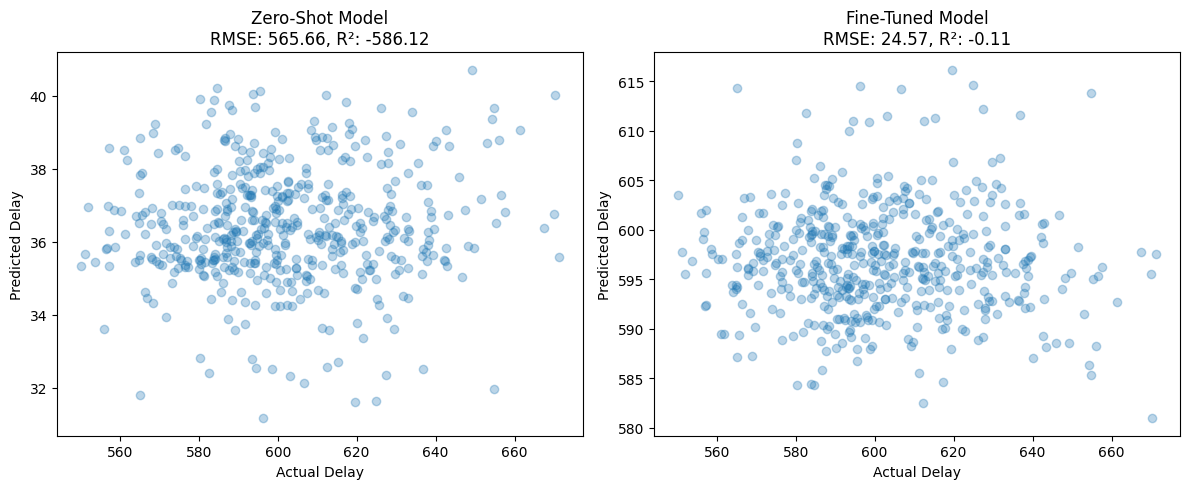

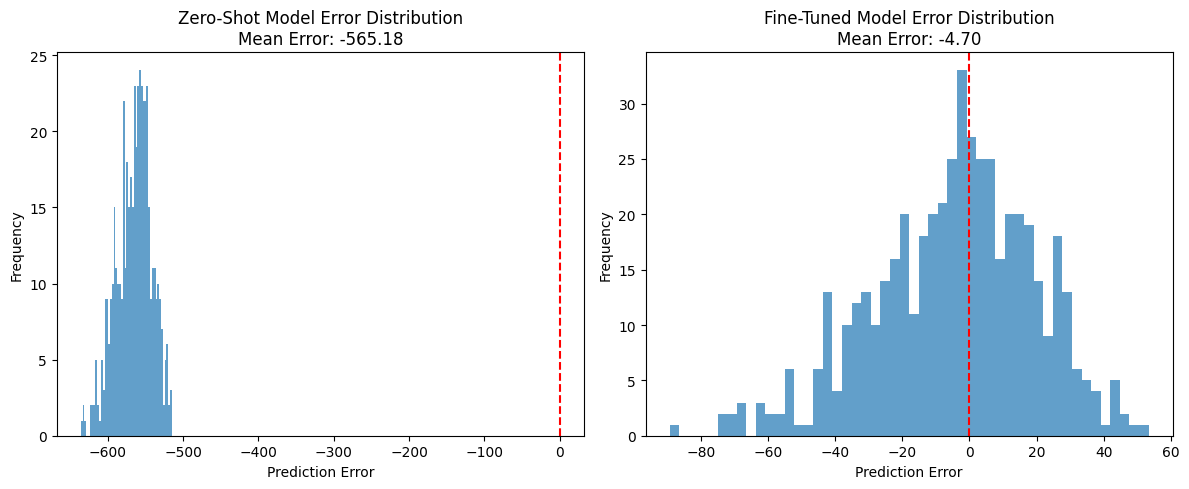

Model Improvement Summary:
RMSE: 565.6612 → 24.5683 (95.66% improvement)
MAE: 565.1811 → 19.0903 (96.62% improvement)
R²: -586.1189 → -0.1076 (99.81% improvement)

Recipe Comparison:
Optimized Recipe: rs;rfz;f;rwz;st;f;f;f;st;f;f;f;f;st;st;f;f;st;st;f;
Best Known Recipe: b;rf;rwz;f;b;b;st;rwz;b;rs;st;rwz;rw;b;rs;rfz;rfz;rs;rf;b

Potential delay improvement: -4.02%


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch

# Function to evaluate model performance
def evaluate_model(model, design_name, recipes, actual_delays, design_graphs, device):
    """
    Evaluate model performance on a set of recipes

    Args:
        model: The model to evaluate
        design_name: Name of the design
        recipes: List of recipe strings to evaluate
        actual_delays: List of actual delay values
        design_graphs: Dictionary mapping design names to PyG Data objects
        device: Device to run computations on

    Returns:
        RMSE, MAE, R², predictions, targets
    """
    model.eval()
    predictions = []

    # Get graph data for this design
    graph_data = design_graphs[design_name]
    graph_data_tuple = (
        graph_data.x.to(device),
        graph_data.edge_index.to(device),
        graph_data.edge_attr.to(device)
    )

    # Process graph embedding once (it's the same for all recipes)
    with torch.no_grad():
        graph_embed = model.aig_encoder(*graph_data_tuple)

    # Process recipes in batches
    batch_size = 32
    for i in range(0, len(recipes), batch_size):
        batch_recipes = recipes[i:i+batch_size]

        # Encode recipes
        encoded_recipes = torch.stack([encode_recipe(recipe) for recipe in batch_recipes]).to(device)

        # Get predictions
        with torch.no_grad():
            # Process recipe data
            recipe_embed = model.recipe_encoder(encoded_recipes)

            # Expand graph embedding to match batch size
            batch_size_current = recipe_embed.shape[0]
            graph_embed_expanded = graph_embed.expand(batch_size_current, -1)

            # Concatenate embeddings
            combined_embed = torch.cat([graph_embed_expanded, recipe_embed], dim=1)

            # Forward pass through the fusion layers
            batch_preds = model(combined_embed).cpu().numpy()
            predictions.extend(batch_preds.flatten())

    # Convert to numpy arrays
    predictions = np.array(predictions)
    targets = np.array(actual_delays)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)

    return rmse, mae, r2, predictions, targets

# Get test data for the target design
test_design_data = last_1000[last_1000['Design'] == target_design]
test_recipes = test_design_data['Recipe'].tolist()
test_delays = test_design_data['Final_Delay'].values

# Evaluate zero-shot model
zero_shot_rmse, zero_shot_mae, zero_shot_r2, zero_shot_preds, zero_shot_targets = evaluate_model(
    model, target_design, test_recipes, test_delays, design_graphs, device
)

# Evaluate fine-tuned model
fine_tuned_rmse, fine_tuned_mae, fine_tuned_r2, fine_tuned_preds, fine_tuned_targets = evaluate_model(
    fine_tuned_model, target_design, test_recipes, test_delays, design_graphs, device
)

# Visualize predictions vs. actual values
plt.figure(figsize=(12, 5))

# Zero-shot model
plt.subplot(1, 2, 1)
plt.scatter(zero_shot_targets, zero_shot_preds, alpha=0.3)
# plt.plot([min(zero_shot_targets), max(zero_shot_targets)], [min(zero_shot_targets), max(zero_shot_targets)], 'r--')
plt.title(f'Zero-Shot Model\nRMSE: {zero_shot_rmse:.2f}, R²: {zero_shot_r2:.2f}')
plt.xlabel('Actual Delay')
plt.ylabel('Predicted Delay')

# Fine-tuned model
plt.subplot(1, 2, 2)
plt.scatter(fine_tuned_targets, fine_tuned_preds, alpha=0.3)
# plt.plot([min(fine_tuned_targets), max(fine_tuned_targets)], [min(fine_tuned_targets), max(fine_tuned_targets)], 'r--')
plt.title(f'Fine-Tuned Model\nRMSE: {fine_tuned_rmse:.2f}, R²: {fine_tuned_r2:.2f}')
plt.xlabel('Actual Delay')
plt.ylabel('Predicted Delay')

plt.tight_layout()
plt.savefig('prediction_comparison.png')
plt.show()

# Visualize error distribution
plt.figure(figsize=(12, 5))

# Zero-shot model errors
plt.subplot(1, 2, 1)
zero_shot_errors = zero_shot_preds - zero_shot_targets
plt.hist(zero_shot_errors, bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.title(f'Zero-Shot Model Error Distribution\nMean Error: {np.mean(zero_shot_errors):.2f}')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

# Fine-tuned model errors
plt.subplot(1, 2, 2)
fine_tuned_errors = fine_tuned_preds - fine_tuned_targets
plt.hist(fine_tuned_errors, bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.title(f'Fine-Tuned Model Error Distribution\nMean Error: {np.mean(fine_tuned_errors):.2f}')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('error_distribution.png')
plt.show()

# Print improvement summary
improvement_rmse = (zero_shot_rmse - fine_tuned_rmse) / zero_shot_rmse * 100
improvement_r2 = (fine_tuned_r2 - zero_shot_r2) / (1 - zero_shot_r2) * 100 if zero_shot_r2 < 1 else 0

print(f"Model Improvement Summary:")
print(f"RMSE: {zero_shot_rmse:.4f} → {fine_tuned_rmse:.4f} ({improvement_rmse:.2f}% improvement)")
print(f"MAE: {zero_shot_mae:.4f} → {fine_tuned_mae:.4f} ({(zero_shot_mae - fine_tuned_mae) / zero_shot_mae * 100:.2f}% improvement)")
print(f"R²: {zero_shot_r2:.4f} → {fine_tuned_r2:.4f} ({improvement_r2:.2f}% improvement)")

# Check if SA optimization has been run
# If not, find the best recipe from the dataset
if 'best_recipe' not in locals() or 'best_score' not in locals():
    # Find the best recipe in the dataset
    train_design_data = combined_data[combined_data['Design'] == target_design]
    best_actual_idx = train_design_data['Final_Delay'].idxmin()
    best_actual_recipe = train_design_data.loc[best_actual_idx, 'Recipe']
    best_actual_delay = train_design_data.loc[best_actual_idx, 'Final_Delay']

    # Use best actual recipe as a placeholder for best recipe
    best_recipe = best_actual_recipe
    best_score = best_actual_delay

    print("\nNote: Simulated Annealing optimization has not been run.")
    print("Using best recipe from dataset for comparison.")
else:
    # If SA has been run but best_actual_recipe is not defined
    if 'best_actual_recipe' not in locals() or 'best_actual_delay' not in locals():
        train_design_data = combined_data[combined_data['Design'] == target_design]
        best_actual_idx = train_design_data['Final_Delay'].idxmin()
        best_actual_recipe = train_design_data.loc[best_actual_idx, 'Recipe']
        best_actual_delay = train_design_data.loc[best_actual_idx, 'Final_Delay']

n_iterations = 1500  # Default value

# Compare optimized recipe with best known recipe
print("\nRecipe Comparison:")
print(f"Optimized Recipe: {best_recipe}")
print(f"Best Known Recipe: {best_actual_recipe}")

# Calculate potential improvement
potential_improvement = (best_actual_delay - best_score) / best_actual_delay * 100
print(f"\nPotential delay improvement: {potential_improvement:.2f}%")

# **10. Model Saving and Loading**
This section implement module to save and load the trained Bulls-Eye model for future use.

In [22]:

# Save the model and results
save_path = f'bulls_eye_{target_design}_results.pt'
torch.save({
    'zero_shot_model': model.state_dict(),
    'fine_tuned_model': fine_tuned_model.state_dict(),
    'metrics': {
        'zero_shot_rmse': zero_shot_rmse,
        'zero_shot_mae': zero_shot_mae,
        'zero_shot_r2': zero_shot_r2,
        'fine_tuned_rmse': fine_tuned_rmse,
        'fine_tuned_mae': fine_tuned_mae,
        'fine_tuned_r2': fine_tuned_r2,
        'improvement_rmse': improvement_rmse,
        'improvement_r2': improvement_r2
    },
    'best_recipe': best_recipe,
    'best_score': best_score,
    'best_actual_recipe': best_actual_recipe,
    'best_actual_delay': best_actual_delay,
    'potential_improvement': potential_improvement
}, save_path)

print(f"\nResults saved to {save_path}")



Results saved to bulls_eye_aes_secworks_orig_results.pt


# **Conclusion**

In this notebook, we implemented the Bulls-Eye framework for logic synthesis QoR prediction, covering data preparation, graph and recipe encoding, zero-shot model training, active few-shot fine-tuning, and simulated annealing-based recipe optimization. The approach enables fast and accurate delay prediction and recipe search for new designs, significantly reducing the need for expensive synthesis runs and demonstrating strong improvements after fine-tuning.